In [20]:
#importing necessary libraries
import seaborn as sns
color_pal = sns.color_palette()
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime
import datetime
from sklearn.model_selection import TimeSeriesSplit
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import scipy.stats as stats

In [21]:
df = pd.read_csv("RB2018.csv").dropna()
for x in range(2019,2023):
    df = pd.concat([df,pd.read_csv(f"RB{x}.csv").dropna()], axis=0)
df = df[df["FPTS/G"] > 5]
df = df.reset_index()

In [22]:
df.corr()

,index,Rank,ATT,Y/A,LG,20+,TD,REC,TGT,Y/R,TD.1,FL,G,FPTS,FPTS/G
index,1.000000,1.000000,-0.811167,-0.204506,-0.509053,-0.566101,-0.679420,-0.692618,-0.702238,0.027856,-0.442111,-0.385284,-0.794139,-0.901611,-0.659903
Rank,1.000000,1.000000,-0.811167,-0.204506,-0.509053,-0.566101,-0.679420,-0.692618,-0.702238,0.027856,-0.442111,-0.385284,-0.794139,-0.901611,-0.659903
ATT,-0.811167,-0.811167,1.000000,0.127591,0.565265,0.680044,0.771207,0.402910,0.411191,-0.083502,0.173235,0.450916,0.592046,0.834779,0.655168
Y/A,-0.204506,-0.204506,0.127591,1.000000,0.480024,0.427136,0.179111,0.007918,0.017253,0.018240,0.053684,0.039791,0.103453,0.189609,0.150378
LG,-0.509053,-0.509053,0.565265,0.480024,1.000000,0.809613,0.502461,0.168452,0.179742,-0.028436,0.039979,0.247395,0.312043,0.508654,0.427688
20+,-0.566101,-0.566101,0.680044,0.427136,0.809613,1.000000,0.614949,0.233834,0.247719,0.016827,0.100016,0.222998,0.349269,0.642860,0.552875
TD,-0.679420,-0.679420,0.771207,0.179111,0.502461,0.614949,1.000000,0.302540,0.313855,-0.027605,0.151632,0.344273,0.417049,0.782428,0.705190
REC,-0.692618,-0.692618,0.402910,0.007918,0.168452,0.233834,0.302540,1.000000,0.989900,-0.022454,0.602108,0.205684,0.550003,0.767125,0.590105
TGT,-0.702238,-0.702238,0.411191,0.017253,0.179742,0.247719,0.313855,0.989900,1.000000,-0.017521,0.605205,0.219372,0.562554,0.770971,0.585481
Y/R,0.027856,0.027856,-0.083502,0.018240,-0.028436,0.016827,-0.027605,-0.022454,-0.017521,1.000000,0.182545,-0.013899,-0.074322,0.017810,0.103745


In [23]:

tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
df = df.sort_index()

fold = 0
preds = []
tests = []
scores = []
dates = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train = train
    test = test
    
    FEATURES = ['ATT', "REC"]
    TARGET = 'FPTS/G'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    dates.append(test["Player"])

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    tests.append(y_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:11.98529	validation_1-rmse:12.72573
[100]	validation_0-rmse:5.38999	validation_1-rmse:4.96271
[200]	validation_0-rmse:3.37737	validation_1-rmse:3.46303
[297]	validation_0-rmse:2.87174	validation_1-rmse:3.42640
[0]	validation_0-rmse:12.11592	validation_1-rmse:8.49468
[100]	validation_0-rmse:5.42925	validation_1-rmse:3.86833
[200]	validation_0-rmse:3.40732	validation_1-rmse:2.77199
[300]	validation_0-rmse:2.89928	validation_1-rmse:2.64249
[400]	validation_0-rmse:2.71282	validation_1-rmse:2.63279
[426]	validation_0-rmse:2.68074	validation_1-rmse:2.63431
[0]	validation_0-rmse:11.78817	validation_1-rmse:11.75862
[100]	validation_0-rmse:5.29488	validation_1-rmse:4.33218
[200]	validation_0-rmse:3.34376	validation_1-rmse:2.09132
[300]	validation_0-rmse:2.86586	validation_1-rmse:2.01929
[303]	validation_0-rmse:2.85778	validation_1-rmse:2.02617
[0]	validation_0-rmse:11.77017	validation_1-rmse:10.82162
[100]	validation_0-rmse:5.23627	validation_1-rmse:3.71635
[200]	validatio

In [24]:
new = pd.read_csv("RB2023.csv").dropna()
new['Prediction'] = reg.predict(new[FEATURES])
new.to_csv("RB-Projections.csv")

% Error Statistics:
count    150.000000
mean      19.255523
std       13.928174
min        0.112881
25%        8.109301
50%       15.894432
75%       28.901105
max       53.692443
Name: % Error, dtype: float64


<AxesSubplot:xlabel='% Error'>

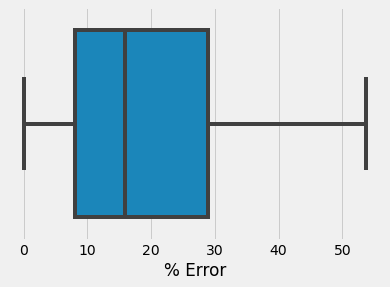

In [25]:
#making csv tracking predictions for each hour and actual results
analysis = pd.DataFrame({'Player': np.concatenate([dates[0], dates[1], dates[2], dates[3], dates[4]]), 'Prediction': np.concatenate([preds[0], preds[1], preds[2], preds[3], preds[4]]), 'Actual': np.concatenate([tests[0].values, tests[1].values, tests[2].values, tests[3].values, tests[4].values])})
analysis["% Error"] = ((analysis["Prediction"]-analysis["Actual"])/analysis["Actual"]).abs()*100
analysis.to_csv('RB-Full_Results.csv')

print("% Error Statistics:")

#printing error metrics, box-plot
print(analysis["% Error"].describe())
sns.boxplot(x=analysis["% Error"])
